# Preps:

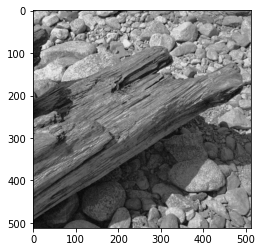

In [2]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import random
data =scipy.io.loadmat('IMAGES_RAW.mat') 
images = data['IMAGESr']
#Show the first image.
plt.imshow(images[:,:,0], cmap='gray')

In [0]:
# Function to sample image patches from the large images. 
def sample_random_square_patches(image, num, width):
  patches =np.zeros([width,width,num]); 
  for k in range(num):
    i, j = random.sample(range(image.shape[0]-width),2)
    patches[:,:,k] = image[i:i+width,j:j+width] 
  return patches

In [0]:
def generate_patches(images,num,width):
  # generate an array containing patches from all images
  num_images = images.shape[2]
  patches = sample_random_square_patches(images[:,:,0],num,width)
  for k in range(num_images-1):
    patch = sample_random_square_patches(images[:,:,k+1],num,width)
    patches = np.dstack((patches,patch))
  n = patches.shape[2]
  res = patches[:,:,0].flatten().reshape((144,1))
  for k in range(n-1):
    col = patches[:,:,k+1].flatten().reshape((144,1))
    res = np.hstack((res,col))
  return res

### (a) & (b):


The update rule for SGD is:
\begin{equation}
V^{t+1} \leftarrow V^{t} - 2 \delta (V^{t}A-X)A^{T}
\end{equation}

In [0]:
from sklearn import linear_model
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

def sgd(images,L,delta,lamb,batch_size = 3,max_iter = 4000,thresh=1e-6):
  # Initialize codebook and other parameters 
  d = 144
  V_curr = preprocessing.normalize(np.random.rand(d,L),axis=0)
  V_record = [V_curr,] # keep track of codebooks through iterations
  delta_record = []
  lasso = linear_model.Lasso(alpha=lamb,fit_intercept=False)

  for i in range(max_iter):
    Xb = generate_patches(images,batch_size,12)
    delta = (0.999**(i))*delta
    # alpha step:
    A = (lasso.fit(V_curr,Xb).coef_).T
    # codebook update:
    grad = np.matmul(np.subtract(np.matmul(V_curr,A),Xb),A.T)
    V_new = preprocessing.normalize(np.subtract(V_curr,delta*grad),axis=0)
    if i % 400 == 0:
      V_record.append(V_new)
      print("400 passed!, currently at iteration: ",i)
    # track code book changes:
    V_diff = np.subtract(V_new,V_curr)
    delta = np.linalg.norm(V_diff,'fro') / np.linalg.norm(V_curr,'fro')
    delta_record.append(delta)
    if delta <= thresh:
      V_record.append(V_new)
      break
    V_curr = V_new
    res = [V_record,delta_record]
  return res

In [0]:
res = sgd(images,200,0.1,0.01)

### (c)

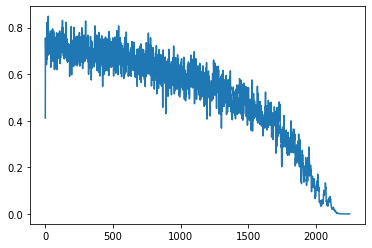

In [47]:
# Monitor the changes in the Frobenius norm of the difference between codebooks across iterations:
deltas = res[1]
plt.plot(range(len(deltas)),deltas)

In [0]:
# Monitor the convergence of SGD by looking at the changes in codebook
def show_codebook(V):
  plt.figure(figsize=(40,20))
  for i in range(200):
    filter_curr = V[:,i].reshape((12,12))
    plt.subplot(20,10,i+1)
    plt.imshow(filter_curr,cmap='gray')

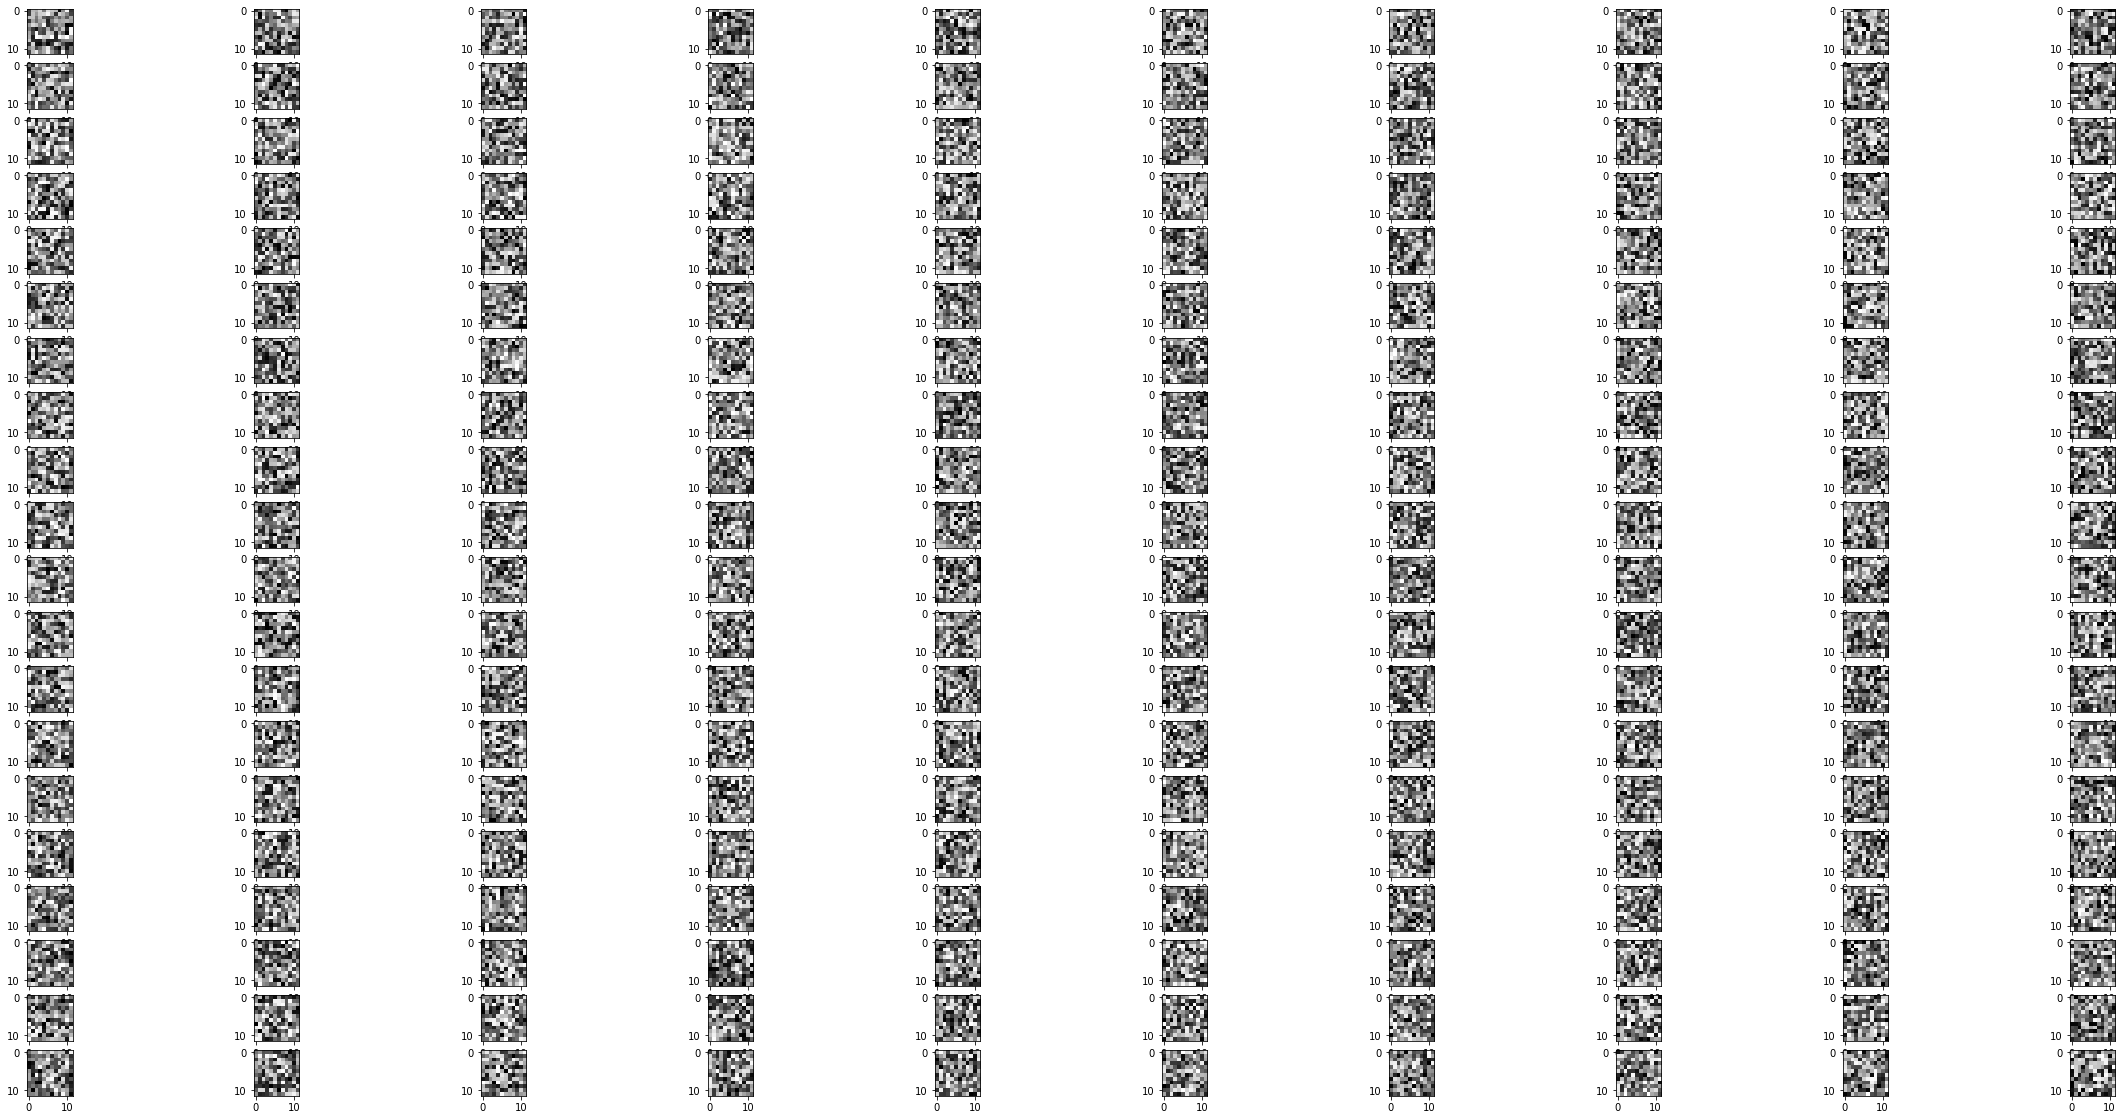

In [49]:
codebooks = res[0]
show_codebook(codebooks[0])

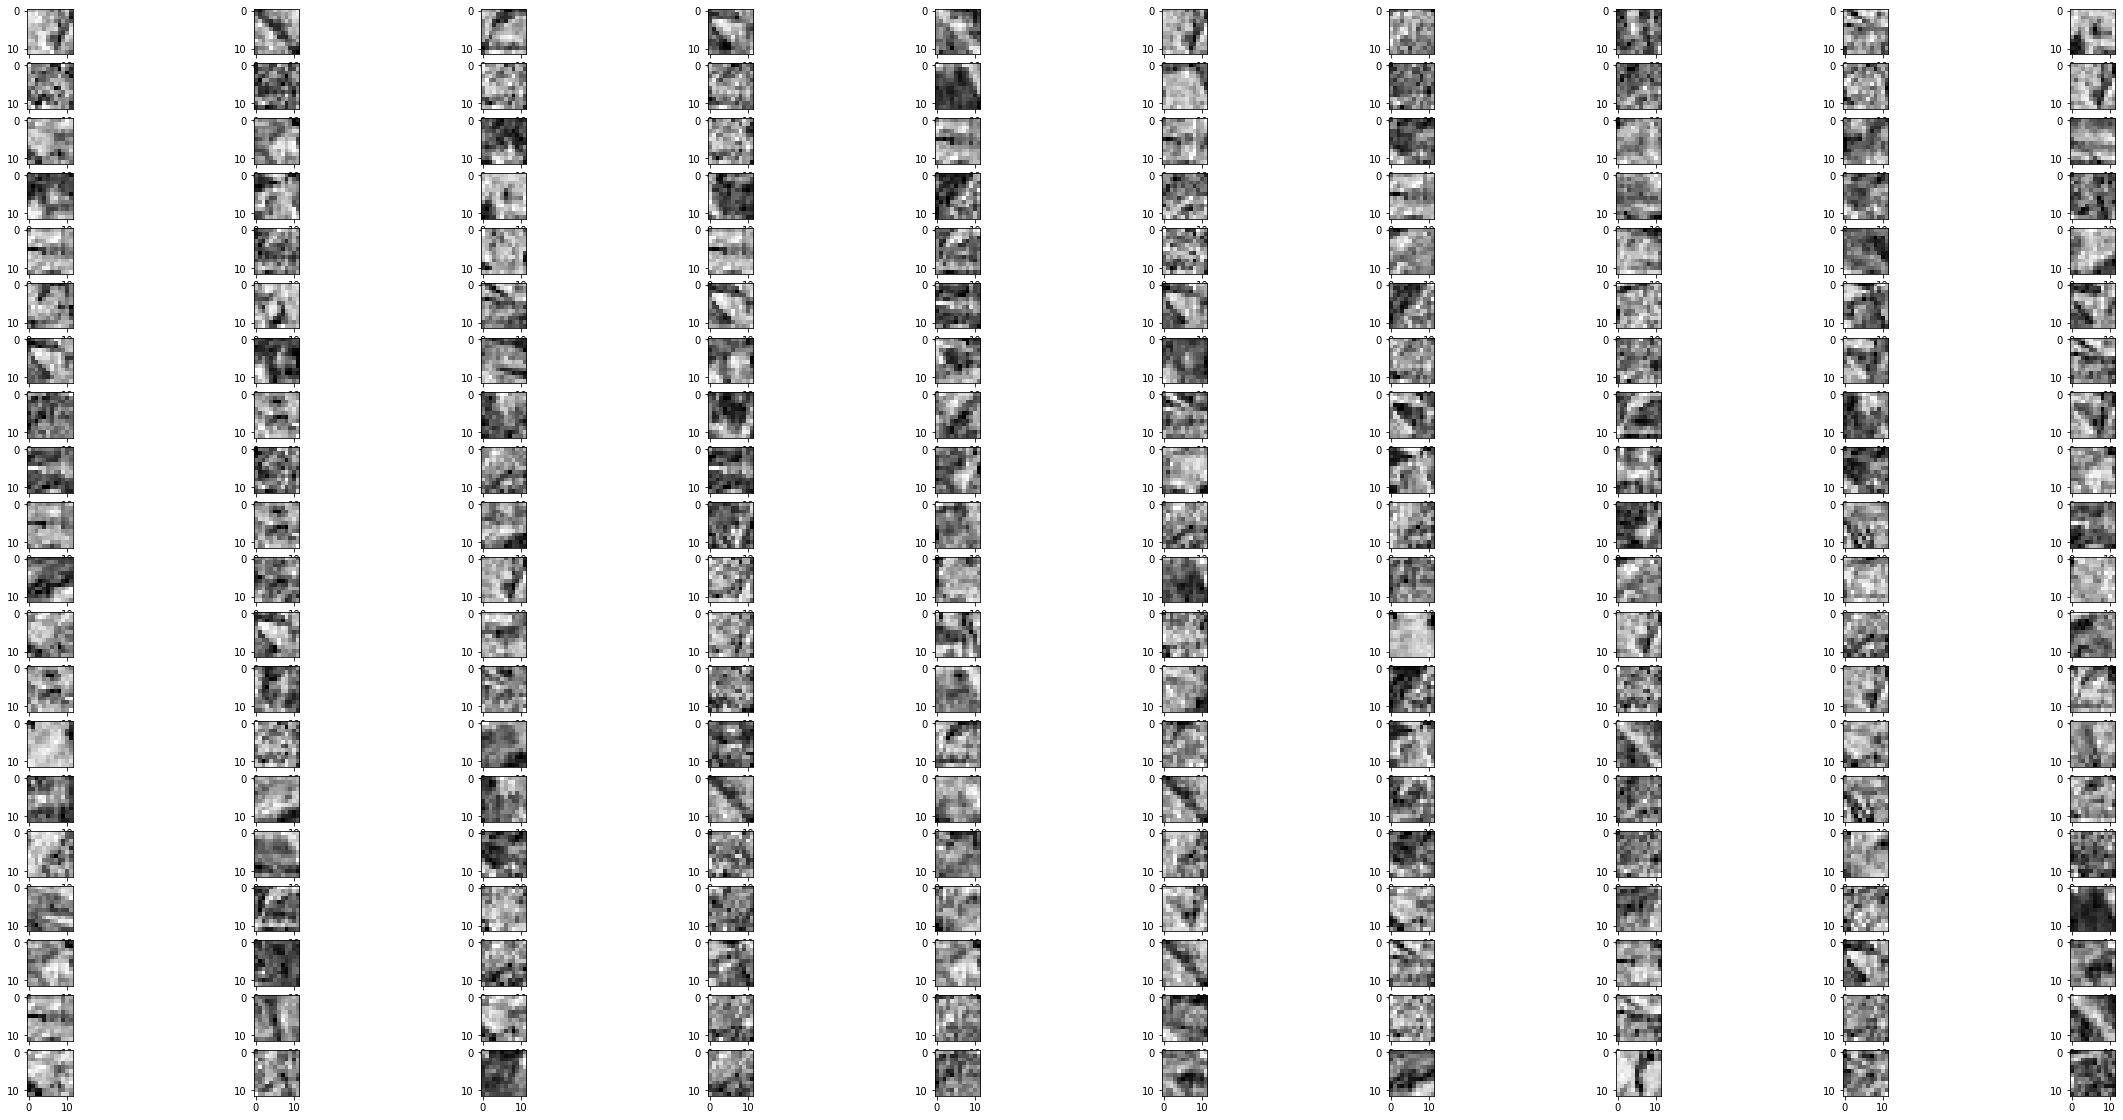

In [50]:
show_codebook(codebooks[2])

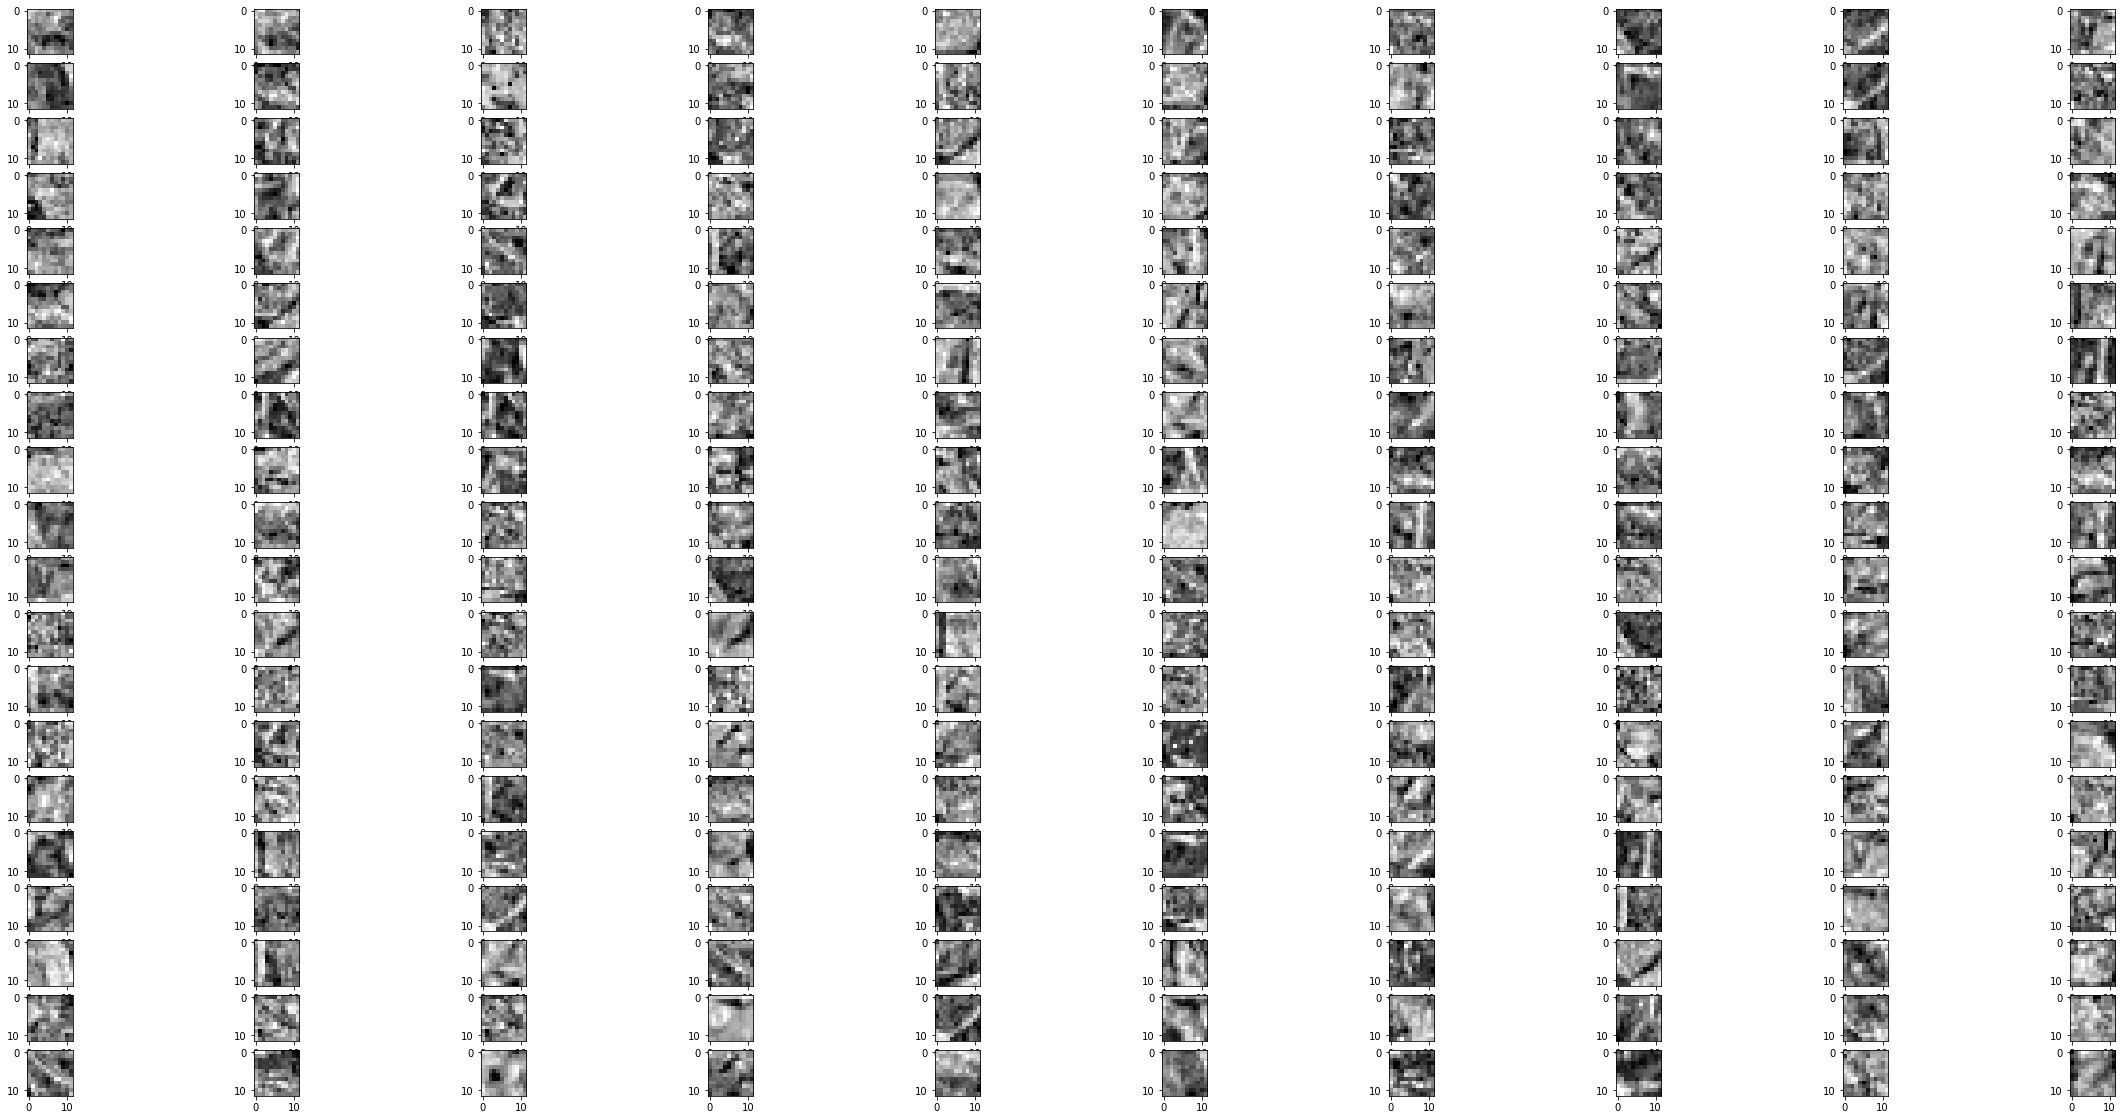

In [51]:
show_codebook(codebooks[4])

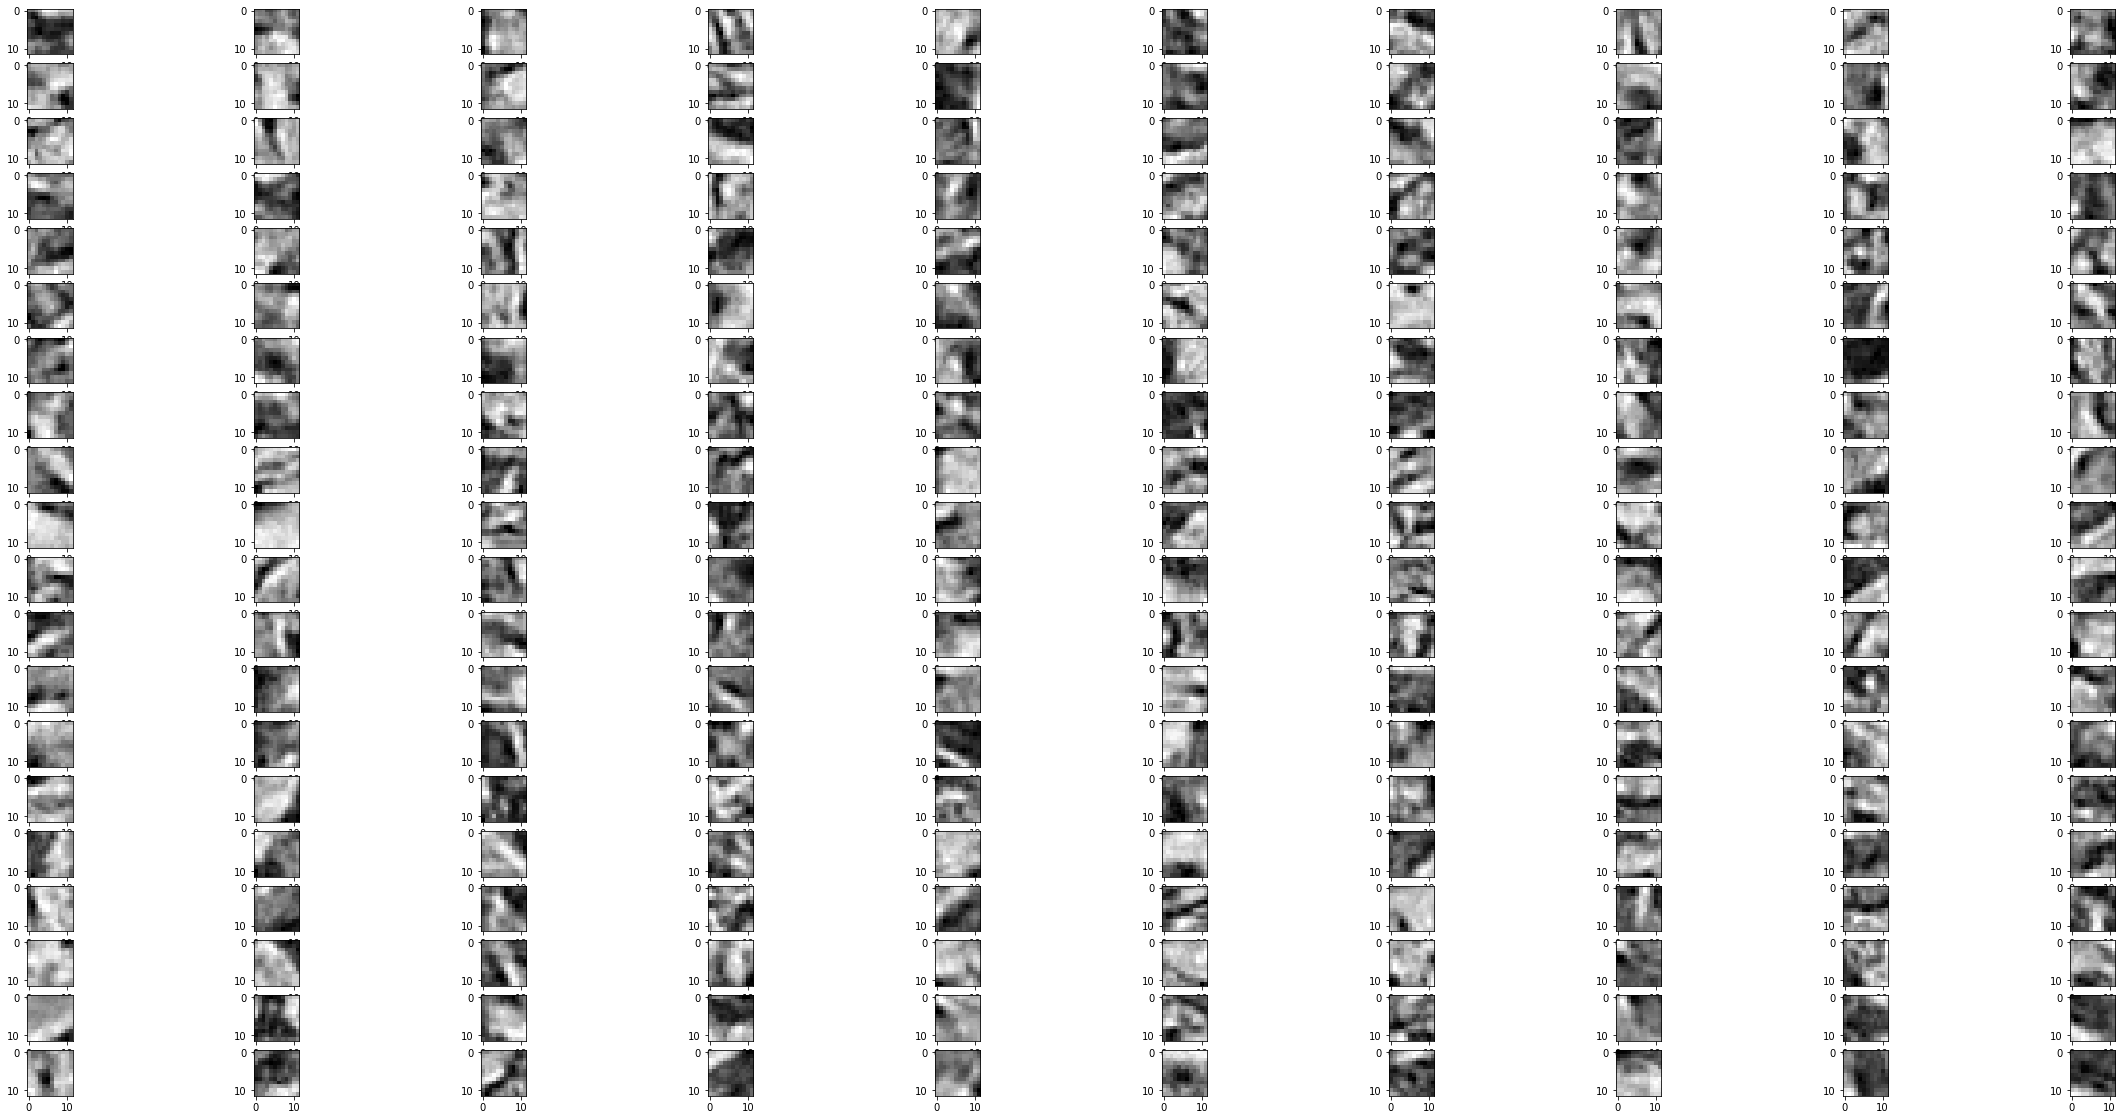

In [52]:
show_codebook(codebooks[-1])

From the codebooks shown above, the results are consistent with the results of the paper. We see that at convergence, the model has trained for filters that capture edge like features, whereas at the beginning the codebook are basically just random noises. The best step size was 0.1 that decreases by 0.999 at each iteration. Higher or lower step size made convergence difficult. The algorithm converges quite quickly with about 2000 iterations provided regularization parameter is reasonably high at 0.01. A lower regularization parameter would make convergence difficult as the algorithm does not filter out noises in the image so edge like featurers are not achieved until many more iterations later. 

### (d)

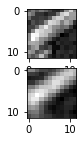

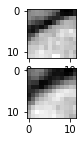

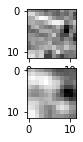

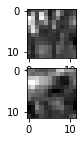

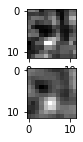

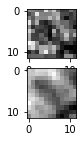

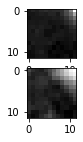

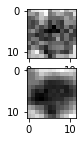

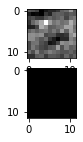

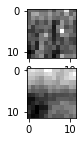

In [79]:
# Generate random patches to be reconstructed
Xb = generate_patches(images,1,12)
V = codebooks[-1]
lasso = linear_model.Lasso(alpha=0.01,fit_intercept=False)

def reconstruct_and_show(X,V,lasso):
  A = lasso.fit(V,X).coef_
  recon = np.zeros(144)
  for i in range(200):
    recon = np.add(recon,A[i]*V[:,i])

  X_image = X.reshape((12,12))
  recon_image = recon.reshape((12,12))

  plt.figure(figsize=(4,2))
  plt.subplot(2,1,1)
  plt.imshow(X_image,cmap='gray')
  plt.subplot(2,1,2)
  plt.imshow(recon_image,cmap='gray')

for i in range(10):
  X_curr = Xb[:,i]
  reconstruct_and_show(X_curr,V,lasso)
  

For the reconstructed image patches, we see that if the original patch had edge like features the reconstructed image is quite close to the original. If the original image was noisy, then the reconstructed image blurs out the noise. 